# Logistic Regression as Elo
[Benjamin Morris](https://twitter.com/skepticalsports/status/1147225488273788929) set me on the right path. The previous experiments used a general purpose classifier that just looked at the rating difference between teams to predict a winner. You can use the logistic regression framework to solve for optimal Elo ratings. So let's do that here

In [1]:
from collections import defaultdict, deque
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-white')

In [2]:
# load the data and drop the away games
df = pd.read_csv('nbaallelo.csv',index_col='game_id')
df = df[df['game_location']!='A'] 

In [3]:
# teams moved around a lot
from_new_to_old_team = {
    'CHO':'CHA','NOP':'NOH','BRK':'NJN','OKC':'SEA','NOK':'NOH','NOH':'CHH','MEM':'VAN','WAS':'WSB','SAC':'KCK','LAC':'SDC','UTA':'NOJ','SDC':'BUF','NJN':'NYN','GSW':'SFW','DLC':'TEX','HOU':'SDR','CHA':'CHH','SAA':'TEX','SAS':'SAA','DEN':'DNA','DNA':'DNR','WSB':'CAP','CAP':'BAL','BAL':'CHZ','CHZ':'CHP','SDS':'SDA','FLO':'MMF','MMF':'MNM','SFW':'PHW','LAL':'MNL','LAS':'ANA','UTS':'LAS','CAR':'HSM','SSL':'CAR','DET':'FTW','MLH':'TRI','STL':'MLH','ATL':'STL','PHI':'SYR','CIN':'ROC','PTC':'PTP','MNP':'PTP','PTP':'MNP','MMP':'NOB','MMT':'MMP','MMS':'MMT','VIR':'WSA','WSA':'OAK'
}

In [4]:
# the basic 538 Elo
def get_elo_ratings(df_local,start_year = 1947):
    K=20
    HFA=100
    SW=0.75
    MOVM=3
    ELOW=400
    INTERCEPT=7.5
    SLOPE=0.006
    POW=0.8
    NEW_TEAM=1300
    year_id = start_year
    ELOW=400
    
    df_local = df_local[df_local.year_id >= start_year]
    team_year_elo = defaultdict(lambda : defaultdict(list))
    
    elo = {}

    for i,row in enumerate(df_local.itertuples()):
        # skip duplicates
        if row[3] != 0:
            continue
        # update the year
        if row[4] != year_id:
            for k in elo:
                elo[k] = SW*elo[k] + (1-SW)*1505
            year_id +=1
            
            # update teams that renamed themselves
            teams1 = set(list(df[df.year_id == year_id-1].team_id.unique()) + list(df[df.year_id == year_id-1].opp_id.unique()))
            teams2 = set(list(df[df.year_id == year_id].team_id.unique()) + list(df[df.year_id == year_id].opp_id.unique()))
            for t in [_ for _ in teams2 if not _ in teams1]:
                if t in from_new_to_old_team and not t in elo and from_new_to_old_team[t] in elo:
                    elo[t] = elo[from_new_to_old_team[t]]
                    team_year_elo[t].update(team_year_elo[from_new_to_old_team[t]])
        
        # get the stats
        t1,t2=row[8],row[14]
        elo_i,elo_n = row[11],row[12]
        opp_elo_i,opp_elo_n = row[17],row[18]
        p1,p2 = row[10],row[16]
        
        # get the Elo
        elo1 = elo.get(t1,NEW_TEAM) + HFA
        if row[-4] == 'N':
            elo1 -= HFA
        elo2 = elo.get(t2,NEW_TEAM)

        # get the win %
        winp = 1.0 / (10 ** (-(elo1-elo2)/ELOW) + 1)
    
        # compute margin of victory correction
        mov = abs(p1-p2)
        elo_diff_w  = (elo2 - elo1)
        mofv_m1 = ((mov+MOVM) ** POW)/(INTERCEPT + SLOPE*(-elo_diff_w))
        mofv_m2 = ((mov+MOVM) ** POW)/(INTERCEPT + SLOPE*(elo_diff_w))

        # find the elo update amount
        if p1 > p2:
            hm,am = 1,-1
            add_t = K*(1-winp)*mofv_m1
        else:
            hm,am = -1,1
            add_t = K*(winp)*mofv_m2

        # apply it
        if row[-4] == 'N':
            elo[t1] = elo1 + hm*add_t
        else:
            elo[t1] = elo1 + hm*add_t - HFA

        elo[t2] = elo2 + am*add_t
        
        # save it
        team_year_elo[t1][year_id].append(elo[t1] - hm*add_t)
        team_year_elo[t2][year_id].append(elo[t2] - am*add_t)
    return team_year_elo
team_year_elo = get_elo_ratings(df)

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

if False:
    import autograd.numpy as np
    import autograd
    def generate_ratings2(dset,teams,weight_recent = 0,HFA=75/173):
        N = len(teams)
        X = []
        Y = []
        for t1,games in dset.items():
            for t2,tW in games:
                v = np.zeros(N)
                v[teams[t1]] = 1
                v[teams[t2]] = -1
                #v[-1] = 70/173
                Y.append(tW)
                X.append(v)
        try:
            w = np.ones_like(Y)
            if weight_recent != 0:
                w = [np.exp(-(i*i/weight_recent)) for i in range(len(Y))]
                w = np.array(w)[::-1]
                w /= w.mean()
            X = np.array(X).astype(np.float)
            Y = np.array(Y).astype(np.float)
            W = 1e-2*np.random.normal(size=(X.shape[1]))
            def loss_f(xt):
                p = 1/(1+np.exp(- (X @ xt + HFA)))
                loss = np.mean(w*(-Y * np.log(p) - (1-Y) *np.log(1-p+1e-12)))
                return loss
            GRAD = autograd.grad(loss_f)
            alpha = 3e-1
            v = np.zeros_like(W)
            for i in range(1000):
                loss = loss_f(W)
                v = 0.9*v - GRAD(W)
                W += (alpha) * v
                #if (i%1000== 0):
                #    break
                if (np.linalg.norm(v) < 1e-2):
                    print('early')
                    break
                if (i%50) == 0:
                    print(loss,)
                if i > 0 and (i%250) ==0:
                    alpha /= 4
            return (W * 173 + 1500,HFA)
        except:
            return ([1500 for i in range(N)],0)
import scipy.optimize as opt
prev_w = None
def log_logit(xs):
    xs = np.array(xs)
    return np.choose(xs > 0,[-np.log(1. + np.exp(-xs)),xs - np.log(1. + np.exp(xs))])
def generate_ratings2(dset,teams,weight_recent = 0,HFA=75/173):
    global prev_w
    N = len(teams)
    X = []
    Y = []
    for t1,games in dset.items():
        for t2,tW in games:
            v = np.zeros(N)
            v[teams[t1]] = 1
            v[teams[t2]] = -1
            #v[-1] = 70/173
            Y.append(tW)
            X.append(v)
    try:
        w = np.ones_like(Y)
        if weight_recent != 0:
            w = [np.exp(-(i*i/weight_recent)) for i in range(len(Y))]
            w = np.array(w)[::-1]
            w /= w.mean()
        X = np.array(X).astype(np.float)
        Y = np.array(Y).astype(np.float)
        if prev_w is None or prev_w.shape[0] != X.shape[1]:
            prev_w = 1e-2*np.random.normal(size=(X.shape[1]))
        W = prev_w


        def loss_f(xt):
            V = X @ xt + HFA
            loss = np.mean(w*(-Y * log_logit(V) - (1-Y) *log_logit(-V)))
            return loss
        res = opt.minimize(loss_f,W)
        W = res.x
        prev_w = W
        return (W * 173 + 1500,HFA)
    except KeyboardInterrupt:
        raise
    except:
        return ([1500 for i in range(N)],0)
def generate_ratings(dset,teams,weight_recent = 0):
    N = len(teams)
    X = []
    Y = []
    for t1,games in dset.items():
        for t2,tW in games:
            v = np.zeros(N)
            v[teams[t1]] = 1
            v[teams[t2]] = -1
            #v[-1] = 70/173
            Y.append(tW)
            X.append(v)
    try:
        clf = linear_model.LogisticRegression()
        if weight_recent != 0:
            w = [np.exp(-(i*i/weight_recent)) for i in range(len(Y))]
            w = np.array(w)[::-1]
            w /= w.mean()
            clf.fit(X,Y,w)
        else:
            clf.fit(X,Y)
        return (clf.coef_[0] * 173 + 1500,clf.intercept_[0])
    except:
        return ([1500 for i in range(N)],0)
hfa_vals = []

def get_lr_ratings(df_local,start_year = 2011,games_std_dev=0):
    correct_r = 0
    total_r = 0
    MAX_HOME_GAMES_PER_TEAM = 30 # 30
    year_id = start_year-1
  
    df_local = df_local[df_local.year_id >= start_year]
    team_year_elo = defaultdict(lambda : defaultdict(list))
    
    dataset = defaultdict(lambda : deque(maxlen=MAX_HOME_GAMES_PER_TEAM))
    
    for i,row in enumerate(df_local.itertuples()):
        # skip duplicates
        if row[3] != 0:
            continue
        # update the year
        if row[4] != year_id:
            year_id +=1
            
            teams1 = set(list(df[df.year_id == year_id-1].team_id.unique()) + list(df[df.year_id == year_id-1].opp_id.unique()))
            teams2 = set(list(df[df.year_id == year_id].team_id.unique()) + list(df[df.year_id == year_id].opp_id.unique()))
            old_to_new = {}
            for t in [_ for _ in teams2 if not _ in teams1]:
                if t in from_new_to_old_team:
                    old_team = from_new_to_old_team[t]
                    team_year_elo[t].update(team_year_elo[old_team])
                    dataset[t] = dataset[old_team]
                    old_to_new[old_team] = t
            # remove the old team
            for t in [t for t in dataset if not t in teams2]:
                del dataset[t]
            # correct the entries
            for team in dataset:
                replaced_teams = [(old_to_new.get(g[0],g[0]),g[1]) for g in dataset[team]]
                dataset[team] = deque(replaced_teams,maxlen=MAX_HOME_GAMES_PER_TEAM)
            teams = {t: i for i,t in enumerate(sorted(teams2))}

        t1,t2=row[8],row[14]
        p1,p2 = row[10],row[16]
        
        # generate a rating
        rate,hfa = generate_ratings(dataset,teams,games_std_dev)
        hfa_vals.append(hfa)
        team_year_elo[t1][year_id].append(rate[teams[t1]])
        team_year_elo[t2][year_id].append(rate[teams[t2]])
        
        if year_id >= 2013:
            correct_r += int(((rate[teams[t1]] - rate[teams[t2]] +hfa) > 0) == (p1 > p2))
            total_r += 1
        # just store the other team and the result
        dataset[t1].append((t2,p1>p2))
        #print('.',end='')
    print(correct_r/total_r)
    return team_year_elo,dataset
team_year_elo_reg,dataset = get_lr_ratings(df,2010,0)

0.6475659229208925


Text(0.5, 1.0, 'Regressed HCA (Last 30 Games weighted)')

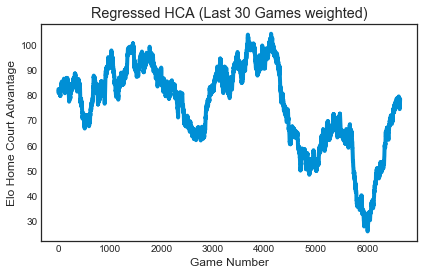

In [6]:
#_ = plt.plot([np.exp(-(i*i/(200**2))) for i in range(100)])
#plt.figure()
_ = plt.plot(173*np.array(hfa_vals)[100*10:])
plt.xlabel('Game Number')
plt.ylabel('Elo Home Court Advantage')
plt.title('Regressed HCA (Last 30 Games weighted)')

Text(0.5, 1.0, '76.487')

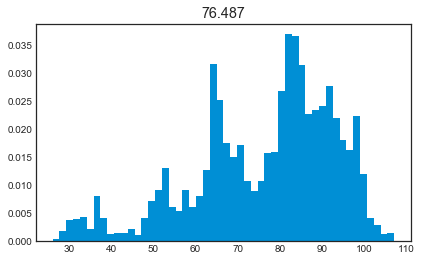

In [7]:
_ = plt.hist(173*np.array(hfa_vals[41*15:]),50,density=True)
plt.title('{:.3f}'.format(173*np.array(hfa_vals[41*15:]).mean()))

In [8]:
for ds,hfa in zip([team_year_elo_reg,team_year_elo],[75,100]):
    correct = 0
    total = 0
    for yr in range(2013,2016):
        ds = {_:ds[_] for _ in ds if yr in ds[_]}
        counter = {k:0 for k in ds}
        for i,row in enumerate(df[df.year_id == yr].itertuples()):
            # skip duplicates
            if row[3] != 0:
                continue
            t1,t2=row[8],row[14]
            p1,p2 = row[10],row[16]

            elo1 = ds[t1][yr][counter[t1]]
            elo2 = ds[t2][yr][counter[t2]]
            correct += int(((elo1-elo2 + hfa) > 0) == (p1 > p2))
            total += 1

            counter[t1] += 1
            counter[t2] += 1
    print(correct/total)

0.6675963488843814
0.6635395537525355


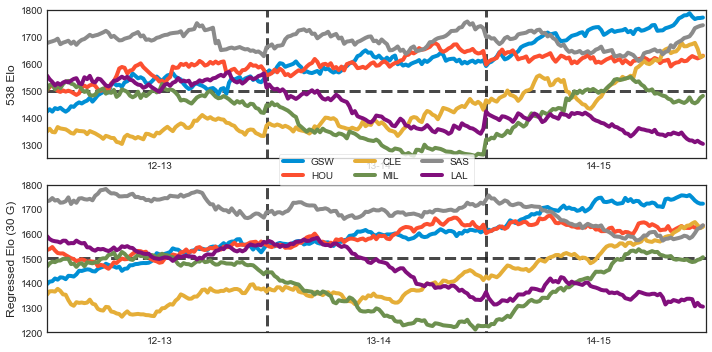

In [9]:
from scipy.ndimage.filters import gaussian_filter1d

teams = ['GSW','HOU','CLE','MIL','SAS','LAL']
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.vlines(82,0,2500,linestyles='dashed',color=(0.1,0.1,0.1),lw=3,alpha=0.8)
plt.vlines(82*2,0,2500,linestyles='dashed',color=(0.1,0.1,0.1),lw=3,alpha=0.8)
plt.hlines(1500,0,82*3,linestyles='dashed',color=(0.1,0.1,0.1),lw=3,alpha=0.8)

for t in teams:
    plt.plot(np.concatenate([team_year_elo[t][y][:82] for y in range(2013,2016)]),label=t)

plt.xticks([42,82+42,42+82*2],['12-13','13-14','14-15'])
plt.xlim(0,82*3)
plt.ylabel('538 Elo')
plt.xlim(0,82*3)
plt.ylim(1250,1800)

plt.subplot(2,1,2)
plt.vlines(82,0,2500,linestyles='dashed',color=(0.1,0.1,0.1),lw=3,alpha=0.8)
plt.vlines(82*2,0,2500,linestyles='dashed',color=(0.1,0.1,0.1),lw=3,alpha=0.8)
plt.hlines(1500,0,82*3,linestyles='dashed',color=(0.1,0.1,0.1),lw=3,alpha=0.8)

for t in teams:
    plt.plot(np.concatenate([team_year_elo_reg[t][y][:82] for y in range(2013,2016)]),label=t)
plt.xticks([42,82+42,42+82*2],['12-13','13-14','14-15'])
plt.xlim(0,82*3)
plt.ylim(1200,1800)
plt.ylabel('Regressed Elo (30 G)')

plt.tight_layout()
plt.legend(loc=8,ncol=3,borderaxespad=0,bbox_to_anchor=(0,1.0,1,0),frameon=True,fontsize=10)
#plt.savefig('elo4.png',edgecolor='w',facecolor='w')

In [10]:
teams = {k:i for i,k in enumerate(sorted([_ for _ in team_year_elo if 2015 in team_year_elo[_]]))}
rate,hfa = generate_ratings(dataset,teams,0)
coeffs = rate
col_names = sorted(dataset.keys())
v = np.argsort(abs(coeffs))[::-1]
coeffs2 = [(coeffs[i2],col_names[i2]) for i2 in v]

print(hfa*173.0)
print('| Variable | Coeff |')
print('|----------|-------|')
for v,n in sorted(coeffs2,reverse=True):
    print('|{:25s}|{:.2f}|'.format(n, v))

77.76946663133926
| Variable | Coeff |
|----------|-------|
|GSW                      |1749.10|
|CLE                      |1699.11|
|SAS                      |1655.38|
|LAC                      |1647.26|
|HOU                      |1644.81|
|ATL                      |1633.64|
|MEM                      |1627.77|
|OKC                      |1583.05|
|DAL                      |1559.62|
|CHI                      |1552.56|
|POR                      |1551.88|
|UTA                      |1537.73|
|NOP                      |1533.68|
|WAS                      |1519.72|
|BOS                      |1506.27|
|TOR                      |1502.36|
|IND                      |1494.39|
|MIL                      |1485.54|
|BRK                      |1476.20|
|PHO                      |1475.12|
|DET                      |1472.54|
|MIA                      |1457.91|
|CHO                      |1452.37|
|DEN                      |1389.98|
|SAC                      |1350.62|
|ORL                      |1319.00|
|PHI

In [11]:
df.iloc[-4:]

,gameorder,lg_id,_iscopy,year_id,date_game,seasongame,is_playoffs,team_id,fran_id,pts,...,win_equiv,opp_id,opp_fran,opp_pts,opp_elo_i,opp_elo_n,game_location,game_result,forecast,notes
game_id,,,,,,,,,,,,,,,,,,,,,
201506090CLE,63154,NBA,0,2015,6/9/2015,99,1,CLE,Cavaliers,96,...,61.826408,GSW,Warriors,91,1797.5032,1790.9591,H,W,0.527843,NaN
201506110CLE,63155,NBA,0,2015,6/11/2015,100,1,CLE,Cavaliers,82,...,60.309792,GSW,Warriors,103,1790.9591,1809.9791,H,L,0.546572,NaN
201506140GSW,63156,NBA,0,2015,6/14/2015,102,1,GSW,Warriors,104,...,68.013329,CLE,Cavaliers,91,1704.3949,1700.7391,H,W,0.765565,NaN
201506170CLE,63157,NBA,0,2015,6/16/2015,102,1,CLE,Cavaliers,97,...,59.290245,GSW,Warriors,105,1813.6349,1822.2881,H,L,0.481450,NaN


In [12]:
if False:
    import autograd.numpy as np
    import autograd

    def generate_ratings2(dset,teams,weight_recent = 0,HFA=75/173):
        N = len(teams)
        X = []
        Y = []
        for t1,games in dset.items():
            for t2,tW in games:
                v = np.zeros(N)
                v[teams[t1]] = 1
                v[teams[t2]] = -1
                #v[-1] = 70/173
                Y.append(tW)
                X.append(v)
        try:
            w = np.ones_like(Y)
            if weight_recent != 0:
                w = [np.exp(-(i*i/weight_recent)) for i in range(len(Y))]
                w = np.array(w)[::-1]
                w /= w.mean()
            X = np.array(X).astype(np.float)
            Y = np.array(Y).astype(np.float)
            W = 1e-2*np.random.normal(size=(X.shape[1]))
            def loss_f(xt):
                p = 1/(1+np.exp(- (X @ xt + HFA)))
                loss = np.mean(w*(-Y * np.log(p) - (1-Y) *np.log(1-p+1e-12)))
                return loss
            GRAD = autograd.grad(loss_f)
            alpha = 3e-1
            v = np.zeros_like(W)
            for i in range(1000):
                loss = loss_f(W)
                v = 0.9*v - GRAD(W)
                W += (alpha) * v
                #if (i%1000== 0):
                #    break
                if (np.linalg.norm(v) < 1e-2):
                    print('early')
                    break
                if (i%50) == 0:
                    print(loss,)
            return (W * 173 + 1500,HFA)
        except:
            return ([1500 for i in range(N)],0)
import scipy.optimize as opt
def generate_ratings2(dset,teams,weight_recent = 0,HFA=75/173):
    N = len(teams)
    X = []
    Y = []
    for t1,games in dset.items():
        for t2,tW in games:
            v = np.zeros(N)
            v[teams[t1]] = 1
            v[teams[t2]] = -1
            #v[-1] = 70/173
            Y.append(tW)
            X.append(v)
    try:
        w = np.ones_like(Y)
        if weight_recent != 0:
            w = [np.exp(-(i*i/weight_recent)) for i in range(len(Y))]
            w = np.array(w)[::-1]
            w /= w.mean()
        X = np.array(X).astype(np.float)
        Y = np.array(Y).astype(np.float)
        W = 1e-2*np.random.normal(size=(X.shape[1]))
        def loss_f(xt):
            V = X @ xt + HFA
            loss = np.mean(w*(-Y * log_logit(V) - (1-Y) *log_logit(-V)))
            return loss
        res = opt.minimize(loss_f,W)
        W = res.x
        return (W * 173 + 1500,HFA)
    except:
        return ([1500 for i in range(N)],0)
teams = {k:i for i,k in enumerate(sorted([_ for _ in team_year_elo if 2015 in team_year_elo[_]]))}
rate,hfa = generate_ratings2(dataset,teams,0)
coeffs = rate
col_names = sorted(dataset.keys())
v = np.argsort(abs(coeffs))[::-1]
coeffs2 = [(coeffs[i2],col_names[i2]) for i2 in v]

print(hfa*173.0)
print('| Variable | Coeff |')
print('|----------|-------|')
for v,n in sorted(coeffs2,reverse=True):
    print('|{:25s}|{:.2f}|'.format(n, v))

75.0
| Variable | Coeff |
|----------|-------|
|GSW                      |1780.67|
|CLE                      |1720.58|
|SAS                      |1675.20|
|LAC                      |1667.05|
|HOU                      |1664.00|
|ATL                      |1645.98|
|MEM                      |1644.10|
|OKC                      |1591.79|
|DAL                      |1569.49|
|POR                      |1559.28|
|CHI                      |1558.85|
|UTA                      |1542.78|
|NOP                      |1538.96|
|WAS                      |1521.82|
|BOS                      |1505.14|
|TOR                      |1500.75|
|IND                      |1491.56|
|MIL                      |1482.98|
|PHO                      |1475.21|
|BRK                      |1474.54|
|DET                      |1468.82|
|MIA                      |1452.55|
|CHO                      |1445.49|
|DEN                      |1377.89|
|SAC                      |1334.34|
|ORL                      |1297.18|
|PHI             